# simulation is done
# now let us fit the model
## XinyuanYan
## xinyuanyan2016@gmail.com
#### code is based on the CCN tutorial (attractor model & large-scale brain network)

## step01:
## fit the reinforcement learning data by attractor model, rescorla-wagner model

### 5 participants

In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import pandas as pd

from src.attractor_model import *



In [2]:
#import participants' data

subdata = pd.read_csv('data_PL_REWARD_020165_for_rstan.csv')
#as dictionary format
subdata.head()



,Unnamed: 0,participant,block_label,trial_block,f_cor,f_inc,cor_option,inc_option,times_seen,rt,accuracy,accuracy_neg
0,0,1,1,1,1,0,2,1,1,1.427829,0,-1
1,1,1,1,2,1,0,1,2,2,0.849174,0,-1
2,2,1,1,3,1,0,2,1,3,0.806818,0,-1
3,3,1,1,4,1,0,2,1,4,1.596714,1,1
4,4,1,1,5,1,0,1,2,5,0.918914,0,-1


In [3]:
# Initialize parameters with default values
pars = default_pars()
expt_pars = default_expt_pars()

In [6]:
# Function that returns the MSE
def get_MSE(params):
    ######
    LR = params[0]

    #let xinyuan try the 1st participants
    

    #create the empty mat with nan to store value
    val = np.full([len(subdata_1),2], np.nan)
    val[0] = 0.5
    
    
    for trial in range(0,len(subdata_1)-1):
        

    
        if subdata_1.accuracy.iloc[trial]==0:
            this_choice = subdata_1.inc_option.iloc[trial]
            val[trial+1][this_choice-1]=val[trial][this_choice-1]+LR*(subdata_1.f_inc.iloc[trial]-val[trial][this_choice-1])
            val[trial+1][1-this_choice+1] = 1-val[trial+1][this_choice-1]
        if subdata_1.accuracy.iloc[trial]==1:
            this_choice = subdata_1.cor_option.iloc[trial]
            val[trial+1][this_choice-1]=val[trial][this_choice-1]+LR*(subdata_1.f_cor.iloc[trial]-val[trial][this_choice-1])
            val[trial+1][1-this_choice+1] = 1-val[trial+1][this_choice-1]
    

#getting the value difference
    val_diff = []

    for kk in range(0,len(subdata_1)):
    
        thisval= val[kk][0]-val[kk][1]
   
        val_diff.append(thisval)

    #end loop here
    
    #print(len(val_diff))
    




    for cPrime in range(0,len(val_diff)):#trial by trial
        
        
        


        pars['coh'] = val_diff[cPrime]*10#to make the value not to be too small
        #print('coherence-:',pars['coh'])
        expt_pars['Ntrials'] = 1 # Total number of trials
        pars['JE'] = params[1]
        pars['JI'] = params[2]
        frThreshold = params[3]
        
    
        results = run_sim(pars, expt_pars, expt='DM')
    
    
        for r1smooth, r2smooth in zip(results['r1smooth'], results['r2smooth']): # loop over trials
            rt1 = next((t for t,r1 in zip(results['t'], r1smooth) if r1 > frThreshold), expt_pars['Ttotal'])
            rt2 = next((t for t,r2 in zip(results['t'], r2smooth) if r2 > frThreshold), expt_pars['Ttotal'])
            #print('rt1 is-',rt1)
            #print('rt2 is-',rt2)
            if rt1 < rt2:
                #allchoice.append(1)
                allRT_temp[cPrime]=float(rt1)
                mse_cal = np.mean((rt_data-allRT_temp)**2)
                
            if rt2 < rt1:
                
                
                #allchoice.append(2)
                allRT_temp[cPrime]=float(rt2)
                mse_cal = np.mean((rt_data-allRT_temp)**2)
                
            if rt2==rt1:
                                    
                                    
                allRT_temp[cPrime]=(1+np.random.rand(1)[0])
                
                mse_cal = np.mean((rt_data-allRT_temp)**2)
            
            if cPrime==len(allRT_temp)-1:
                
                mse_cal_final =  mse_cal
                
            
            
            
        #print('RT:',allRT)
        
        
        #print('lr-',params[0])
        #print('JE-',params[1])
        #print('JI-',params[2])
        #print('threshold-',params[3])


    return mse_cal_final


In [7]:
from scipy.optimize import minimize
import scipy.optimize as spo
#allchoice = []

######loop for 10 participants#####
allsub_para = np.zeros([10,4])

for kk in range(1,6):
    
    print(kk)
    
    
    subdata_1= subdata[(subdata.participant==kk)]
    rt_data = subdata_1['rt']+1
    allRT_temp = np.zeros(len(subdata_1))
    print(len(allRT_temp))

    # Optimization (recovering the parameters)
    initial_guess = [0.6,0.25,-0.03,10]

    bnds = ((0, 1), (0, 1),(-1,0),(9,30))

    res = minimize(get_MSE, initial_guess,method='SLSQP',bounds=bnds,options={'eps': 1e-2})
    #res = spo.dual_annealing(get_MSE, bounds=bnds, x0=initial_guess)
    #spo.differential_evolution(get_MSE, bounds=bnds,x0=initial_guess)
    #res = spo.least_squares(get_MSE, initial_guess)
    #print(res.x)
    allsub_para[kk-1]=res.x

    


1
215
2
218
3
224
4
225
5
224


In [8]:
#trans to pd.dataframe and then save it in csv
df_allsub_para = pd.DataFrame(allsub_para)
#set the column names
df_allsub_para.columns = ['learning-rate','JE','JI','threshold']  
#write into csv
df_allsub_para.to_csv('allsub_para.csv')

## simulation and check

In [19]:
# Initialize parameters with default values
#pars = default_pars()
#expt_pars = default_expt_pars()


def get_firingrate(params):
    ######
    LR = params[0]

    #let xinyuan try the 1st participants
    

    #create the empty mat with nan to store value
    val = np.full([len(subdata_1),2], np.nan)
    val[0] = 0.5
    
    
    for trial in range(0,len(subdata_1)-1):
        

    
        if subdata_1.accuracy.iloc[trial]==0:
            this_choice = subdata_1.inc_option.iloc[trial]
            val[trial+1][this_choice-1]=val[trial][this_choice-1]+LR*(subdata_1.f_inc.iloc[trial]-val[trial][this_choice-1])
            val[trial+1][1-this_choice+1] = 1-val[trial+1][this_choice-1]
        if subdata_1.accuracy.iloc[trial]==1:
            this_choice = subdata_1.cor_option.iloc[trial]
            val[trial+1][this_choice-1]=val[trial][this_choice-1]+LR*(subdata_1.f_cor.iloc[trial]-val[trial][this_choice-1])
            val[trial+1][1-this_choice+1] = 1-val[trial+1][this_choice-1]
    

    #getting the value difference
    val_diff = []

    for kk in range(0,len(subdata_1)):
    
        thisval= val[kk][0]-val[kk][1]
   
        val_diff.append(thisval)

    #end loop here
    
    #print(len(val_diff))
    



    for cPrime in range(0,len(val_diff)):#trial by trial
        
        
        


        pars['coh'] = val_diff[cPrime]*10#to make the value not to be too small
        #print('coherence-:',pars['coh'])
        expt_pars['Ntrials'] = 1 # Total number of trials
        pars['JE'] = params[1]
        pars['JI'] = params[2]
        frThreshold = params[3]
        
    
        results = run_sim(pars, expt_pars, expt='DM')
        ##get the firing rate
        firingrate1 = results['r1smooth']#
        firingrate2 = results['r2smooth']#
        

    
    
        for r1smooth, r2smooth in zip(results['r1smooth'], results['r2smooth']): # loop over trials
            rt1 = next((t for t,r1 in zip(results['t'], r1smooth) if r1 > frThreshold), expt_pars['Ttotal'])
            rt2 = next((t for t,r2 in zip(results['t'], r2smooth) if r2 > frThreshold), expt_pars['Ttotal'])
            #print('rt1 is-',rt1)
            #print('rt2 is-',rt2)
            if rt1 < rt2:
                #allchoice.append(1)
                allRT_temp[cPrime]=float(rt1)
              
            if rt2 < rt1:
                
                
                #allchoice.append(2)
                allRT_temp[cPrime]=float(rt2)
               
                
            if rt2==rt1:
                                    
                                    
                allRT_temp[cPrime]=(1+np.random.rand(1)[0])
                

            



    return allRT_temp,firingrate1,firingrate2



In [20]:
df_allsub_para = pd.read_csv('allsub_para.csv')

thissub_para = np.zeros([4])
thissub_para[0] = df_allsub_para['learning-rate'][1]
thissub_para[1] = df_allsub_para['JE'][1]
thissub_para[2] = df_allsub_para['JI'][1]
thissub_para[3] = df_allsub_para['threshold'][1]




subdata_1= subdata[(subdata.participant==2)]
rt_data = subdata_1['rt']
allRT_temp = np.zeros(len(subdata_1))
suballRT,sub_fr1,sub_fr2= get_firingrate(thissub_para)

(array([14., 74., 56., 37., 10., 14.,  3.,  5.,  3.,  2.]),
 array([0.35714285, 0.4823662 , 0.60758956, 0.73281292, 0.85803627,
        0.98325963, 1.10848299, 1.23370634, 1.3589297 , 1.48415305,
        1.60937641]),
 <BarContainer object of 10 artists>)

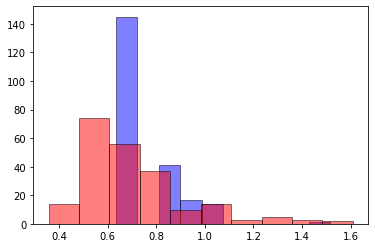

In [21]:
import seaborn as sns

# matplotlib histogram
plt.hist(suballRT-1, color = 'blue', edgecolor = 'black',alpha = 0.5,label='fit RT')
plt.hist(subdata_1['rt'],color = 'red',edgecolor='black',alpha = 0.5,label='RT')